In [1]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report

from keras.optimizers import SGD
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.
/home/adminpnarayanan/anaconda2/envs/dl4keras/lib/python3.5/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [3]:
#%%
class MiniVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1

        # if we are using "channels first", update the input shape
        # and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1

        # first CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(32, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # second CONV => RELU => CONV => RELU => POOL layer set
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model
    
#%%

In [6]:
print("[INFO] loading CIFAR-10 data...")
((trainX, trainY), (testX, testY)) = cifar10.load_data()
print(trainX.shape)
print(testX.shape)

[INFO] loading CIFAR-10 data...
(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [7]:
trainX = trainX.astype("float") / 255.0
testX = testX.astype("float") / 255.0

In [8]:
# convert the labels from integers to vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

In [9]:
# initialize the label names for the CIFAR-10 dataset
labelNames = ["airplane", "automobile", "bird", "cat", "deer","dog", "frog", "horse", "ship", "truck"]

In [12]:
# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(lr=0.01, decay=0.01 / 10, momentum=0.9, nesterov=True)
model = MiniVGGNet.build(width=32, height=32, depth=3, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

[INFO] compiling model...


In [13]:
no_epochs=10
# train the network
print("[INFO] training network...")
H = model.fit(trainX, trainY, validation_data=(testX, testY),batch_size=64, epochs=no_epochs, verbose=1)

[INFO] training network...
Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 325s - loss: 1.6443 - acc: 0.4440 - val_loss: 1.2141 - val_acc: 0.5559
Epoch 2/10
50000/50000 [==============================] - 329s - loss: 1.1670 - acc: 0.5889 - val_loss: 1.0009 - val_acc: 0.6385
Epoch 3/10
50000/50000 [==============================] - 329s - loss: 1.0004 - acc: 0.6461 - val_loss: 0.8827 - val_acc: 0.6885
Epoch 4/10
50000/50000 [==============================] - 331s - loss: 0.9066 - acc: 0.6778 - val_loss: 0.8455 - val_acc: 0.7046
Epoch 5/10
50000/50000 [==============================] - 331s - loss: 0.8479 - acc: 0.7023 - val_loss: 0.7898 - val_acc: 0.7236
Epoch 6/10
50000/50000 [==============================] - 336s - loss: 0.8036 - acc: 0.7171 - val_loss: 0.7904 - val_acc: 0.7255
Epoch 7/10
50000/50000 [==============================] - 327s - loss: 0.7671 - acc: 0.7293 - val_loss: 0.7458 - val_acc: 0.7393
Epoch 8/10
50000/500

In [17]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=64)
print(classification_report(testY.argmax(axis=1),predictions.argmax(axis=1), target_names=labelNames))

[INFO] evaluating network...
             precision    recall  f1-score   support

   airplane       0.80      0.76      0.78      1000
 automobile       0.88      0.86      0.87      1000
       bird       0.76      0.57      0.65      1000
        cat       0.59      0.59      0.59      1000
       deer       0.67      0.76      0.71      1000
        dog       0.70      0.61      0.65      1000
       frog       0.77      0.88      0.82      1000
      horse       0.80      0.80      0.80      1000
       ship       0.82      0.91      0.86      1000
      truck       0.81      0.85      0.83      1000

avg / total       0.76      0.76      0.76     10000



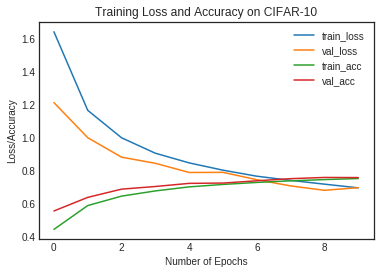

In [16]:
# plot the training loss and accuracy
%matplotlib inline
plt.style.use("seaborn-white")
plt.figure()
plt.plot(np.arange(0, no_epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, no_epochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, no_epochs), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, no_epochs), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on CIFAR-10")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend()
#plt.show()